In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
from utils_unet_resunet import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model.models import Model_3
from model.losses import WBCE
root_path = 'imgs/' 

In [3]:
# Define data type (L8-Landsat8, S2-Sentinel2, S1-Sentinel1)
img_type = 'FUSION'

if img_type == 'FUSION':
    image_stack = np.load(root_path+'New_Images/fus_stack.npy')
    

if img_type == 'OPT':
    image_stack = np.load(root_path+'New_Images/opt_stack.npy')
    
    
if img_type == 'SAR':
    image_stack = np.load(root_path+'New_Images/sar_stack.npy')
print('Image stack:', image_stack.shape)

final_mask1 = np.load(root_path+'New_Images/'+'final_mask1.npy')
print('Labels stack:', final_mask1.shape)

Image stack: (17729, 9202, 12)


In [5]:
# Create tile mask
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
#plt.imshow(mask_tiles)

Tiles size:  2000 1750
Mask size:  (10000, 7000)
mask:  (10000, 7000)
image stack:  (10000, 7000, 12)
ref : (10000, 7000)


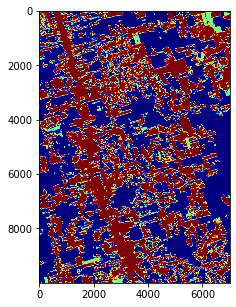

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

In [7]:
# Define tiles for training, validation, and test sets
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

In [8]:
# Create ixd image to extract patches
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [9]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   17110 Number of validation patches 4116


In [10]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(1158, 128, 128) (341, 128, 128)


In [11]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, batch_y = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = tf.keras.utils.to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)


In [12]:
exp = 2
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [13]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'unet'
if method == 'unet':
   model = build_unet(input_shape, nb_filters, number_class)

if method == 'resunet':
   model = build_resunet(input_shape, nb_filters, number_class)

model = Model_3(nb_filters, number_class)

In [14]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-3 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
#loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [15]:
metrics_all = []
times=30
for tm in range(0,times):
    print('time: ', tm)

    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    
    loss = weighted_categorical_crossentropy(weights)
    #loss = WBCE(weights = weights)
    #loss = WBCE(weights = weights, class_indexes = [0, 1])

    #if method == 'unet':
    #   model = build_unet(input_shape, nb_filters, number_class)

    #if method == 'resunet':
    #   model = build_resunet(input_shape, nb_filters, number_class)
    
    model = Model_3(nb_filters, number_class)
    model.build((None,)+input_shape)
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min') ---- val_accuracy
    #checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
    callbacks_list = [earlystop, checkpoint]
    # train the model
    start_training = time.time()
    history = model.fit(train_gen_crops,
                              steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                              validation_data=valid_gen_crops,
                              validation_steps=len(X_valid)*3//valid_gen.batch_size,
                              epochs=100,
                              callbacks=callbacks_list)
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

time:  0
Model: "model_3_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  537440    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
decoder (UNET_Decoder)       multiple                  332000    
_________________________________________________________________
opt_classifier (Classifier)  multiple                  195       
_________________________________________________________________
sar_classifier (Classifier)  multiple                  195       
_________________________________________________________________
fus_classifier (Classifier)  multiple                  195       
Total params: 1,406,327
Trainable params: 1,406,313
Non-trainable params: 14
_____________________________________

Epoch 1/100
108/108 [==============================] - 18s 154ms/step - opt_accuracy: 0.8370 - sar_accuracy: 0.7371 - fus_accuracy: 0.8229 - opt_loss: 0.0949 - sar_loss: 0.1402 - fusion_loss: 0.1013 - loss: 0.3364 - val_opt_accuracy: 0.8256 - val_sar_accuracy: 0.7513 - val_fus_accuracy: 0.8294 - val_opt_loss: 0.1147 - val_sar_loss: 0.1217 - val_fusion_loss: 0.1042 - val_loss: 0.3406

Epoch 00001: val_loss improved from inf to 0.34058, saving model to imgs/experiments/exp2/models\unet_1.h5
Epoch 2/100
108/108 [==============================] - 16s 149ms/step - opt_accuracy: 0.8711 - sar_accuracy: 0.7438 - fus_accuracy: 0.8644 - opt_loss: 0.0761 - sar_loss: 0.1383 - fusion_loss: 0.0781 - loss: 0.2925 - val_opt_accuracy: 0.8443 - val_sar_accuracy: 0.7519 - val_fus_accuracy: 0.8437 - val_opt_loss: 0.1003 - val_sar_loss: 0.1232 - val_fusion_loss: 0.0959 - val_loss: 0.3194

Epoch 00002: val_loss improved from 0.34058 to 0.31938, saving model to imgs/experiments/exp2/models\unet_1.h5
Epoch 3/


Epoch 00004: val_loss did not improve from 0.34458
Epoch 5/100
108/108 [==============================] - 18s 164ms/step - opt_accuracy: 0.8926 - sar_accuracy: 0.7938 - fus_accuracy: 0.8891 - opt_loss: 0.0586 - sar_loss: 0.1087 - fusion_loss: 0.0596 - loss: 0.2268 - val_opt_accuracy: 0.8543 - val_sar_accuracy: 0.7949 - val_fus_accuracy: 0.8534 - val_opt_loss: 0.1632 - val_sar_loss: 0.1237 - val_fusion_loss: 0.1622 - val_loss: 0.4491

Epoch 00005: val_loss did not improve from 0.34458
Epoch 6/100
108/108 [==============================] - 18s 170ms/step - opt_accuracy: 0.8956 - sar_accuracy: 0.7961 - fus_accuracy: 0.8934 - opt_loss: 0.0573 - sar_loss: 0.1095 - fusion_loss: 0.0578 - loss: 0.2246 - val_opt_accuracy: 0.8535 - val_sar_accuracy: 0.8068 - val_fus_accuracy: 0.8542 - val_opt_loss: 0.1619 - val_sar_loss: 0.1479 - val_fusion_loss: 0.1653 - val_loss: 0.4751

Epoch 00006: val_loss did not improve from 0.34458
Epoch 7/100
108/108 [==============================] - 18s 168ms/step - 

Epoch 1/100
108/108 [==============================] - 28s 236ms/step - opt_accuracy: 0.8269 - sar_accuracy: 0.7302 - fus_accuracy: 0.8011 - opt_loss: 0.0981 - sar_loss: 0.1423 - fusion_loss: 0.1113 - loss: 0.3516 - val_opt_accuracy: 0.8322 - val_sar_accuracy: 0.7571 - val_fus_accuracy: 0.8292 - val_opt_loss: 0.1149 - val_sar_loss: 0.1234 - val_fusion_loss: 0.1114 - val_loss: 0.3497

Epoch 00001: val_loss improved from inf to 0.34969, saving model to imgs/experiments/exp2/models\unet_5.h5
Epoch 2/100
108/108 [==============================] - 25s 230ms/step - opt_accuracy: 0.8651 - sar_accuracy: 0.7537 - fus_accuracy: 0.8530 - opt_loss: 0.0798 - sar_loss: 0.1328 - fusion_loss: 0.0849 - loss: 0.2976 - val_opt_accuracy: 0.8313 - val_sar_accuracy: 0.7614 - val_fus_accuracy: 0.8296 - val_opt_loss: 0.1558 - val_sar_loss: 0.1253 - val_fusion_loss: 0.1497 - val_loss: 0.4308

Epoch 00002: val_loss did not improve from 0.34969
Epoch 3/100
108/108 [==============================] - 25s 235ms/ste


Epoch 00001: val_loss improved from inf to 0.37808, saving model to imgs/experiments/exp2/models\unet_6.h5
Epoch 2/100
108/108 [==============================] - 28s 262ms/step - opt_accuracy: 0.8712 - sar_accuracy: 0.7514 - fus_accuracy: 0.8642 - opt_loss: 0.0751 - sar_loss: 0.1351 - fusion_loss: 0.0784 - loss: 0.2885 - val_opt_accuracy: 0.8399 - val_sar_accuracy: 0.7364 - val_fus_accuracy: 0.8392 - val_opt_loss: 0.1270 - val_sar_loss: 0.1277 - val_fusion_loss: 0.1225 - val_loss: 0.3772

Epoch 00002: val_loss improved from 0.37808 to 0.37724, saving model to imgs/experiments/exp2/models\unet_6.h5
Epoch 3/100
108/108 [==============================] - 28s 262ms/step - opt_accuracy: 0.8805 - sar_accuracy: 0.7320 - fus_accuracy: 0.8782 - opt_loss: 0.0680 - sar_loss: 0.1380 - fusion_loss: 0.0692 - loss: 0.2752 - val_opt_accuracy: 0.8393 - val_sar_accuracy: 0.7425 - val_fus_accuracy: 0.8367 - val_opt_loss: 0.1520 - val_sar_loss: 0.1315 - val_fusion_loss: 0.1525 - val_loss: 0.43610681 - sa

Epoch 1/100
108/108 [==============================] - 35s 300ms/step - opt_accuracy: 0.8324 - sar_accuracy: 0.7350 - fus_accuracy: 0.8054 - opt_loss: 0.0988 - sar_loss: 0.1421 - fusion_loss: 0.1146 - loss: 0.3556 - val_opt_accuracy: 0.8486 - val_sar_accuracy: 0.7631 - val_fus_accuracy: 0.8315 - val_opt_loss: 0.1050 - val_sar_loss: 0.1184 - val_fusion_loss: 0.1130 - val_loss: 0.3364

Epoch 00001: val_loss improved from inf to 0.33642, saving model to imgs/experiments/exp2/models\unet_7.h5
Epoch 2/100
108/108 [==============================] - 31s 290ms/step - opt_accuracy: 0.8676 - sar_accuracy: 0.7520 - fus_accuracy: 0.8522 - opt_loss: 0.0783 - sar_loss: 0.1329 - fusion_loss: 0.0862 - loss: 0.2974 - val_opt_accuracy: 0.8442 - val_sar_accuracy: 0.7713 - val_fus_accuracy: 0.8399 - val_opt_loss: 0.1180 - val_sar_loss: 0.1276 - val_fusion_loss: 0.1197 - val_loss: 0.3654

Epoch 00002: val_loss did not improve from 0.33642
Epoch 3/100
108/108 [==============================] - 32s 293ms/ste


Epoch 00005: val_loss did not improve from 0.31725
Epoch 6/100
108/108 [==============================] - 36s 337ms/step - opt_accuracy: 0.8922 - sar_accuracy: 0.7821 - fus_accuracy: 0.8891 - opt_loss: 0.0607 - sar_loss: 0.1134 - fusion_loss: 0.0612 - loss: 0.2353 - val_opt_accuracy: 0.8536 - val_sar_accuracy: 0.7823 - val_fus_accuracy: 0.8522 - val_opt_loss: 0.1240 - val_sar_loss: 0.1216 - val_fusion_loss: 0.1248 - val_loss: 0.3703

Epoch 00006: val_loss did not improve from 0.31725
Epoch 7/100
108/108 [==============================] - 36s 339ms/step - opt_accuracy: 0.8938 - sar_accuracy: 0.7927 - fus_accuracy: 0.8916 - opt_loss: 0.0576 - sar_loss: 0.1078 - fusion_loss: 0.0576 - loss: 0.2230 - val_opt_accuracy: 0.8552 - val_sar_accuracy: 0.7986 - val_fus_accuracy: 0.8517 - val_opt_loss: 0.1561 - val_sar_loss: 0.1603 - val_fusion_loss: 0.1633 - val_loss: 0.4797

Epoch 00007: val_loss did not improve from 0.31725
Epoch 8/100
108/108 [==============================] - 37s 343ms/step - 


Epoch 00010: val_loss did not improve from 0.34209
Epoch 11/100
108/108 [==============================] - 41s 378ms/step - opt_accuracy: 0.9066 - sar_accuracy: 0.7384 - fus_accuracy: 0.9060 - opt_loss: 0.0463 - sar_loss: 0.1383 - fusion_loss: 0.0464 - loss: 0.2310 - val_opt_accuracy: 0.8542 - val_sar_accuracy: 0.7497 - val_fus_accuracy: 0.8532 - val_opt_loss: 0.1671 - val_sar_loss: 0.1201 - val_fusion_loss: 0.1678 - val_loss: 0.4550

Epoch 00011: val_loss did not improve from 0.34209
Epoch 00011: early stopping
time:  10
Model: "model_3_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  537440    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
decoder (UNET_Decoder)       multiple                  

108/108 [==============================] - 43s 399ms/step - opt_accuracy: 0.8672 - sar_accuracy: 0.7452 - fus_accuracy: 0.8578 - opt_loss: 0.0771 - sar_loss: 0.1354 - fusion_loss: 0.0802 - loss: 0.2927 - val_opt_accuracy: 0.8458 - val_sar_accuracy: 0.7546 - val_fus_accuracy: 0.8408 - val_opt_loss: 0.1158 - val_sar_loss: 0.1183 - val_fusion_loss: 0.1109 - val_loss: 0.3450

Epoch 00002: val_loss did not improve from 0.32620
Epoch 3/100
108/108 [==============================] - 44s 414ms/step - opt_accuracy: 0.8770 - sar_accuracy: 0.7600 - fus_accuracy: 0.8710 - opt_loss: 0.0701 - sar_loss: 0.1288 - fusion_loss: 0.0719 - loss: 0.2708 - val_opt_accuracy: 0.8511 - val_sar_accuracy: 0.7706 - val_fus_accuracy: 0.8471 - val_opt_loss: 0.1499 - val_sar_loss: 0.1222 - val_fusion_loss: 0.1438 - val_loss: 0.4159

Epoch 00003: val_loss did not improve from 0.32620
Epoch 4/100
108/108 [==============================] - 44s 408ms/step - opt_accuracy: 0.8826 - sar_accuracy: 0.7771 - fus_accuracy: 0.87


Epoch 00006: val_loss did not improve from 0.31137
Epoch 7/100
108/108 [==============================] - 48s 448ms/step - opt_accuracy: 0.8925 - sar_accuracy: 0.7728 - fus_accuracy: 0.8906 - opt_loss: 0.0585 - sar_loss: 0.1233 - fusion_loss: 0.0589 - loss: 0.2407 - val_opt_accuracy: 0.8525 - val_sar_accuracy: 0.7723 - val_fus_accuracy: 0.8523 - val_opt_loss: 0.1207 - val_sar_loss: 0.1196 - val_fusion_loss: 0.1222 - val_loss: 0.3625

Epoch 00007: val_loss did not improve from 0.31137
Epoch 8/100
108/108 [==============================] - 48s 450ms/step - opt_accuracy: 0.8979 - sar_accuracy: 0.7715 - fus_accuracy: 0.8966 - opt_loss: 0.0544 - sar_loss: 0.1234 - fusion_loss: 0.0546 - loss: 0.2324 - val_opt_accuracy: 0.8385 - val_sar_accuracy: 0.7764 - val_fus_accuracy: 0.8386 - val_opt_loss: 0.1664 - val_sar_loss: 0.1265 - val_fusion_loss: 0.1650 - val_loss: 0.4579

Epoch 00008: val_loss did not improve from 0.31137
Epoch 9/100
108/108 [==============================] - 48s 451ms/step - 


Epoch 00011: val_loss did not improve from 0.30877
Epoch 00011: early stopping
time:  14
Model: "model_3_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  537440    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
decoder (UNET_Decoder)       multiple                  332000    
_________________________________________________________________
opt_classifier (Classifier)  multiple                  195       
_________________________________________________________________
sar_classifier (Classifier)  multiple                  195       
_________________________________________________________________
fus_classifier (Classifier)  multiple                  195       
Total params: 1,406,327
Trainabl

108/108 [==============================] - 54s 503ms/step - opt_accuracy: 0.8784 - sar_accuracy: 0.7605 - fus_accuracy: 0.8722 - opt_loss: 0.0692 - sar_loss: 0.1323 - fusion_loss: 0.0720 - loss: 0.2735 - val_opt_accuracy: 0.8467 - val_sar_accuracy: 0.7381 - val_fus_accuracy: 0.8437 - val_opt_loss: 0.1110 - val_sar_loss: 0.1287 - val_fusion_loss: 0.1116 - val_loss: 0.3512

Epoch 00003: val_loss did not improve from 0.33668
Epoch 4/100
108/108 [==============================] - 54s 505ms/step - opt_accuracy: 0.8822 - sar_accuracy: 0.7610 - fus_accuracy: 0.8787 - opt_loss: 0.0662 - sar_loss: 0.1328 - fusion_loss: 0.0680 - loss: 0.2669 - val_opt_accuracy: 0.8413 - val_sar_accuracy: 0.7861 - val_fus_accuracy: 0.8398 - val_opt_loss: 0.1353 - val_sar_loss: 0.1216 - val_fusion_loss: 0.1353 - val_loss: 0.3922

Epoch 00004: val_loss did not improve from 0.33668
Epoch 5/100
108/108 [==============================] - 53s 492ms/step - opt_accuracy: 0.8863 - sar_accuracy: 0.7850 - fus_accuracy: 0.88


Epoch 00007: val_loss did not improve from 0.32612
Epoch 8/100
108/108 [==============================] - 60s 562ms/step - opt_accuracy: 0.8981 - sar_accuracy: 0.7871 - fus_accuracy: 0.8965 - opt_loss: 0.0551 - sar_loss: 0.1143 - fusion_loss: 0.0553 - loss: 0.2247 - val_opt_accuracy: 0.8591 - val_sar_accuracy: 0.7962 - val_fus_accuracy: 0.8583 - val_opt_loss: 0.1443 - val_sar_loss: 0.1468 - val_fusion_loss: 0.1482 - val_loss: 0.4394

Epoch 00008: val_loss did not improve from 0.32612
Epoch 9/100
108/108 [==============================] - 62s 580ms/step - opt_accuracy: 0.9017 - sar_accuracy: 0.7962 - fus_accuracy: 0.9003 - opt_loss: 0.0524 - sar_loss: 0.1105 - fusion_loss: 0.0524 - loss: 0.2153 - val_opt_accuracy: 0.8537 - val_sar_accuracy: 0.8052 - val_fus_accuracy: 0.8529 - val_opt_loss: 0.1785 - val_sar_loss: 0.1610 - val_fusion_loss: 0.1823 - val_loss: 0.5219

Epoch 00009: val_loss did not improve from 0.32612
Epoch 10/100
108/108 [==============================] - 61s 565ms/step -

Epoch 1/100
108/108 [==============================] - 71s 634ms/step - opt_accuracy: 0.8305 - sar_accuracy: 0.7293 - fus_accuracy: 0.8222 - opt_loss: 0.0963 - sar_loss: 0.1429 - fusion_loss: 0.1057 - loss: 0.3449 - val_opt_accuracy: 0.8435 - val_sar_accuracy: 0.7359 - val_fus_accuracy: 0.8394 - val_opt_loss: 0.1169 - val_sar_loss: 0.1260 - val_fusion_loss: 0.1150 - val_loss: 0.3579

Epoch 00001: val_loss improved from inf to 0.35793, saving model to imgs/experiments/exp2/models\unet_18.h5
Epoch 2/100
108/108 [==============================] - 66s 615ms/step - opt_accuracy: 0.8728 - sar_accuracy: 0.7519 - fus_accuracy: 0.8649 - opt_loss: 0.0747 - sar_loss: 0.1347 - fusion_loss: 0.0782 - loss: 0.2876 - val_opt_accuracy: 0.8295 - val_sar_accuracy: 0.7534 - val_fus_accuracy: 0.8227 - val_opt_loss: 0.1191 - val_sar_loss: 0.1226 - val_fusion_loss: 0.1205 - val_loss: 0.3622

Epoch 00002: val_loss did not improve from 0.35793
Epoch 3/100
108/108 [==============================] - 68s 634ms/st


Epoch 00005: val_loss did not improve from 0.31995
Epoch 6/100
108/108 [==============================] - 74s 688ms/step - opt_accuracy: 0.8861 - sar_accuracy: 0.7825 - fus_accuracy: 0.8838 - opt_loss: 0.0643 - sar_loss: 0.1140 - fusion_loss: 0.0646 - loss: 0.2429 - val_opt_accuracy: 0.8533 - val_sar_accuracy: 0.7904 - val_fus_accuracy: 0.8528 - val_opt_loss: 0.1228 - val_sar_loss: 0.1332 - val_fusion_loss: 0.1249 - val_loss: 0.3808

Epoch 00006: val_loss did not improve from 0.31995
Epoch 7/100
108/108 [==============================] - 74s 687ms/step - opt_accuracy: 0.8880 - sar_accuracy: 0.7913 - fus_accuracy: 0.8867 - opt_loss: 0.0613 - sar_loss: 0.1102 - fusion_loss: 0.0613 - loss: 0.2328 - val_opt_accuracy: 0.8494 - val_sar_accuracy: 0.7792 - val_fus_accuracy: 0.8499 - val_opt_loss: 0.1201 - val_sar_loss: 0.1247 - val_fusion_loss: 0.1201 - val_loss: 0.3648

Epoch 00007: val_loss did not improve from 0.31995
Epoch 8/100
108/108 [==============================] - 74s 688ms/step - 

Epoch 1/100
108/108 [==============================] - 94s 838ms/step - opt_accuracy: 0.8261 - sar_accuracy: 0.7369 - fus_accuracy: 0.8220 - opt_loss: 0.0976 - sar_loss: 0.1421 - fusion_loss: 0.1026 - loss: 0.3422 - val_opt_accuracy: 0.8350 - val_sar_accuracy: 0.7587 - val_fus_accuracy: 0.8370 - val_opt_loss: 0.1165 - val_sar_loss: 0.1230 - val_fusion_loss: 0.1114 - val_loss: 0.3509

Epoch 00001: val_loss improved from inf to 0.35093, saving model to imgs/experiments/exp2/models\unet_22.h5
Epoch 2/100
108/108 [==============================] - 89s 829ms/step - opt_accuracy: 0.8688 - sar_accuracy: 0.7623 - fus_accuracy: 0.8648 - opt_loss: 0.0776 - sar_loss: 0.1289 - fusion_loss: 0.0795 - loss: 0.2859 - val_opt_accuracy: 0.8413 - val_sar_accuracy: 0.7562 - val_fus_accuracy: 0.8381 - val_opt_loss: 0.1212 - val_sar_loss: 0.1236 - val_fusion_loss: 0.1164 - val_loss: 0.3612

Epoch 00002: val_loss did not improve from 0.35093
Epoch 3/100
108/108 [==============================] - 88s 823ms/st


Epoch 00005: val_loss did not improve from 0.33029
Epoch 6/100
108/108 [==============================] - 97s 902ms/step - opt_accuracy: 0.8965 - sar_accuracy: 0.7948 - fus_accuracy: 0.8949 - opt_loss: 0.0561 - sar_loss: 0.1089 - fusion_loss: 0.0564 - loss: 0.2214 - val_opt_accuracy: 0.8416 - val_sar_accuracy: 0.8049 - val_fus_accuracy: 0.8437 - val_opt_loss: 0.1399 - val_sar_loss: 0.1703 - val_fusion_loss: 0.1506 - val_loss: 0.4608

Epoch 00006: val_loss did not improve from 0.33029
Epoch 7/100
108/108 [==============================] - 108s 1s/step - opt_accuracy: 0.8991 - sar_accuracy: 0.8004 - fus_accuracy: 0.8979 - opt_loss: 0.0530 - sar_loss: 0.1062 - fusion_loss: 0.0530 - loss: 0.2122 - val_opt_accuracy: 0.8558 - val_sar_accuracy: 0.7551 - val_fus_accuracy: 0.8537 - val_opt_loss: 0.1308 - val_sar_loss: 0.1419 - val_fusion_loss: 0.1296 - val_loss: 0.4022

Epoch 00007: val_loss did not improve from 0.33029
Epoch 8/100
108/108 [==============================] - 101s 943ms/step - o


Epoch 00010: val_loss did not improve from 0.31907
Epoch 11/100
108/108 [==============================] - 105s 976ms/step - opt_accuracy: 0.9098 - sar_accuracy: 0.8083 - fus_accuracy: 0.9090 - opt_loss: 0.0456 - sar_loss: 0.1026 - fusion_loss: 0.0454 - loss: 0.1937 - val_opt_accuracy: 0.8465 - val_sar_accuracy: 0.7915 - val_fus_accuracy: 0.8432 - val_opt_loss: 0.1627 - val_sar_loss: 0.1233 - val_fusion_loss: 0.1631 - val_loss: 0.4491

Epoch 00011: val_loss did not improve from 0.31907
Epoch 00011: early stopping
time:  25
Model: "model_3_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
opt_encoder (UNET_Encoder)   multiple                  537440    
_________________________________________________________________
sar_encoder (UNET_Encoder)   multiple                  536288    
_________________________________________________________________
decoder (UNET_Decoder)       multiple                 

Epoch 2/100
108/108 [==============================] - 107s 1s/step - opt_accuracy: 0.8642 - sar_accuracy: 0.7675 - fus_accuracy: 0.8518 - opt_loss: 0.0784 - sar_loss: 0.1285 - fusion_loss: 0.0821 - loss: 0.2890 - val_opt_accuracy: 0.8353 - val_sar_accuracy: 0.7875 - val_fus_accuracy: 0.8356 - val_opt_loss: 0.1151 - val_sar_loss: 0.1207 - val_fusion_loss: 0.1114 - val_loss: 0.3472

Epoch 00002: val_loss did not improve from 0.33385
Epoch 3/100
108/108 [==============================] - 114s 1s/step - opt_accuracy: 0.8766 - sar_accuracy: 0.7780 - fus_accuracy: 0.8694 - opt_loss: 0.0719 - sar_loss: 0.1229 - fusion_loss: 0.0738 - loss: 0.2687 - val_opt_accuracy: 0.8425 - val_sar_accuracy: 0.7991 - val_fus_accuracy: 0.8413 - val_opt_loss: 0.1435 - val_sar_loss: 0.1511 - val_fusion_loss: 0.1466 - val_loss: 0.4412

Epoch 00003: val_loss did not improve from 0.33385
Epoch 4/100
108/108 [==============================] - 109s 1s/step - opt_accuracy: 0.8811 - sar_accuracy: 0.7730 - fus_accuracy


Epoch 00006: val_loss did not improve from 0.32716
Epoch 7/100
108/108 [==============================] - 122s 1s/step - opt_accuracy: 0.9021 - sar_accuracy: 0.7938 - fus_accuracy: 0.9003 - opt_loss: 0.0508 - sar_loss: 0.1103 - fusion_loss: 0.0514 - loss: 0.2125 - val_opt_accuracy: 0.8560 - val_sar_accuracy: 0.7978 - val_fus_accuracy: 0.8545 - val_opt_loss: 0.1351 - val_sar_loss: 0.1517 - val_fusion_loss: 0.1404 - val_loss: 0.4272

Epoch 00007: val_loss did not improve from 0.32716
Epoch 8/100
108/108 [==============================] - 123s 1s/step - opt_accuracy: 0.9041 - sar_accuracy: 0.7968 - fus_accuracy: 0.9026 - opt_loss: 0.0489 - sar_loss: 0.1091 - fusion_loss: 0.0493 - loss: 0.2074 - val_opt_accuracy: 0.8510 - val_sar_accuracy: 0.7985 - val_fus_accuracy: 0.8513 - val_opt_loss: 0.1493 - val_sar_loss: 0.1421 - val_fusion_loss: 0.1503 - val_loss: 0.4417

Epoch 00008: val_loss did not improve from 0.32716
Epoch 9/100
108/108 [==============================] - 122s 1s/step - opt_ac


Epoch 00009: val_loss did not improve from 0.37297
Epoch 10/100
108/108 [==============================] - 137s 1s/step - opt_accuracy: 0.9062 - sar_accuracy: 0.8185 - fus_accuracy: 0.9049 - opt_loss: 0.0480 - sar_loss: 0.0968 - fusion_loss: 0.0480 - loss: 0.1928 - val_opt_accuracy: 0.8591 - val_sar_accuracy: 0.8080 - val_fus_accuracy: 0.8580 - val_opt_loss: 0.1522 - val_sar_loss: 0.1360 - val_fusion_loss: 0.1548 - val_loss: 0.4430

Epoch 00010: val_loss did not improve from 0.37297
Epoch 11/100
108/108 [==============================] - 140s 1s/step - opt_accuracy: 0.9088 - sar_accuracy: 0.8175 - fus_accuracy: 0.9076 - opt_loss: 0.0459 - sar_loss: 0.0975 - fusion_loss: 0.0460 - loss: 0.1894 - val_opt_accuracy: 0.8535 - val_sar_accuracy: 0.8020 - val_fus_accuracy: 0.8521 - val_opt_loss: 0.1880 - val_sar_loss: 0.1366 - val_fusion_loss: 0.1890 - val_loss: 0.5136

Epoch 00011: val_loss did not improve from 0.37297
Epoch 00011: early stopping
time:  29
Model: "model_3_30"
________________

In [16]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

#if method == 'unet':
#   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

new_model = Model_3(nb_filters, number_class)
new_model.build((None,)+input_shape)
adam = Adam(lr = 1e-3 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
new_model.compile(optimizer=adam, loss=loss, metrics=['accuracy'], run_eagerly=True)

for tm in range(0,times):
    print('time: ', tm)
    #model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    #for l in range(1, len(model.layers)):
    #    new_model.layers[l].set_weights(model.layers[l].get_weights())
    new_model.load_weights(path_models+ '/' + method +'_'+str(tm)+'.h5')
    
    start_test = time.time()
    patch_t = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            _, _, predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1])
            del predictions_
    end_test =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)

    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    time_ts.append(end_test)
    del prob_recontructed, patches_pred
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)


0.0 -8.0
time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9
time:  10
time:  11
time:  12
time:  13
time:  14
time:  15
time:  16
time:  17
time:  18
time:  19
time:  20
time:  21
time:  22
time:  23
time:  24
time:  25
time:  26
time:  27
time:  28
time:  29


In [17]:
# Compute mean of the tm predictions maps
prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


(-0.5, 6999.5, 9999.5, -0.5)

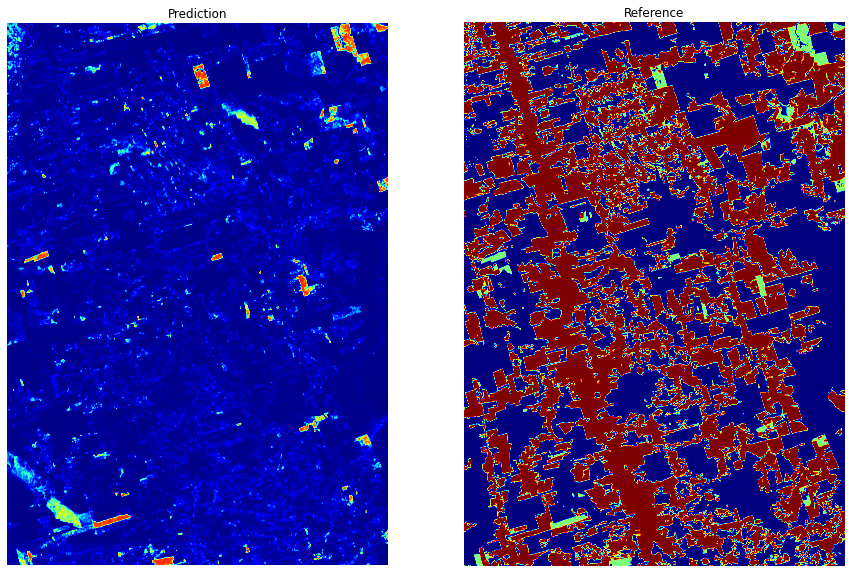

In [18]:
# Plot mean map and reference
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
plt.title('Prediction')
ax1.imshow(mean_prob, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(122)
plt.title('Reference')
ax2.imshow(final_mask1, cmap ='jet')
ax2.axis('off')

In [19]:
# Computing metrics
mean_prob = mean_prob[:final_mask1.shape[0], :final_mask1.shape[1]]
ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50
Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)
    
metrics_ = matrics_AA_recall(ProbList, mean_prob, final_mask1, mask_amazon_ts, 625)
np.save(path_exp+'/acc_metrics.npy',metrics_)

0.9729374786218007


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.9530816117111517


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.9332257448005027


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.9133698778898537


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.8935140109792047


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.8736581440685557


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.8538022771579067
0.8339464102472578
0.8140905433366088
0.7942346764259598
0.7743788095153108
0.7545229426046618
0.7346670756940128
0.7148112087833638
0.6949553418727148
0.6750994749620658
0.6552436080514168
0.6353877411407678
0.6155318742301188
0.5956760073194698
0.5758201404088208
0.5559642734981718
0.5361084065875228
0.5162525396768738
0.49639667276622484
0.47654080585557584
0.4566849389449269
0.4368290720342779
0.4169732051236289
0.3971173382129799
0.3772614713023309
0.3574056043916819
0.3375497374810329
0.3176938705703839
0.2978380036597349
0.2779821367490859
0.2581262698384369
0.2382704029277879
0.2184145360171389
0.1985586691064899
0.1787028021958409
0.158846935285192
0.138991068374543
0.119135201463894
0.099279334553245
0.079423467642596
0.059567600731947
0.039711733821298
0.019855866910649
0.0


In [20]:
# Complete NaN values
metrics_copy = metrics_.copy()
metrics_copy = complete_nan_values(metrics_copy)

mAP 0.8875491742752496


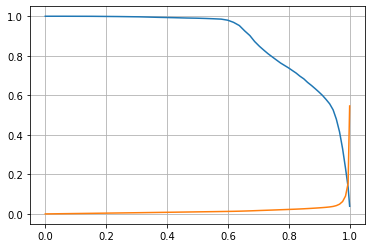

In [21]:
# Comput Mean Average Precision (mAP) score 
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]
AA = metrics_copy[:,2]
    
DeltaR = Recall[1:]-Recall[:-1]
AP = np.sum(Precision[:-1]*DeltaR)
print('mAP', AP)

# Plot Recall vs. Precision curve
plt.close('all')
plt.plot(metrics_copy[:,0],metrics_copy[:,1])
plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()